# Handwritten Character Recognition  
## Shaolun Du

# 1. Abstract

In machine learning and statistics, classification is the problem of identifying a set of categories from a training set of data. Pattern classification methods based on learning-from-examples have
been widely applied to character recognition from the 1990s and have brought forth
significant improvements of recognition accuracies [1]. In this report, we investigate the characters recognition and classifications. 

# 2. Introduction

In this report, we use the handwritten characters to do the feature extraction and classify the identifying characters among our training data set. We try to classify three characters, period ".", "0" and "1". In the following section, we first prepare our images from the zip file "pngs" and glob all images that we want to use as our training set in the future. Then we determine six features of the images in order to recognize among our data. After that, we solve the determined matrix to classify the three characters. We first separate the period and then we further separate "0" and "1" to get the optimal solution and our solved x as W. Finally, we test our method by using all data.

# 3. Approaches

In this section, we will use the classification method to separate three characters from our handwritten characters file. 

## 3.1 Images Preparation

Firstly, we download our handwritten characters file and import glob and PIL to prepare to deal with the png files.

In [1]:
import zipfile
with zipfile.ZipFile("pngs.zip","r") as zip_ref:
    zip_ref.extractall()
from PIL import Image
import glob
%pylab inline
from numpy import *
set_printoptions(linewidth=200)

Populating the interactive namespace from numpy and matplotlib


Then we can use glob to select the specific pngs and show the image by using imshow() as below. Here, we selected all classmates images of ".", "0" and "1". We use a.shape in python to show give the dimensions for our pngs. Then we use h and w to be our height and width and create a for loop to print the image. 

pngs/000_20170329_adhishch__0.png
(125, 100, 4)
(125, 100) uint8 255


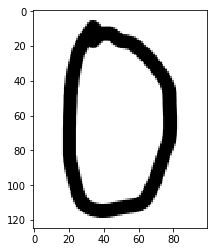

In [2]:
pngs = []
pngs += glob.glob('pngs/*__0.png')
pngs += glob.glob('pngs/*_09.png')
pngs += glob.glob('pngs/*__1.png')
#print(pngs)
for png in pngs:
    print (png)
    img = Image.open(png)
    imshow(img)
    a = array(img)
    print(a.shape)
    a = a[:,:,0] #select the red layer(because red,green,blue all the same)
    print(a.shape,a.dtype,a.max())
    a = array(255-a,dtype=float)
    h,w = a.shape        #h is the height, w is the width
    break

## 3.2 Feature Extraction

In the first part, we create a subset of the images in order to test our classifier method in the future. Here, we use four classmates data and the total number of the images in our subpngs is 119. We use these 119 images to be our training data and test our classified method. 

In [3]:
subpngs = []
for png in pngs:
    if png[-15:-4] == 'aforthma_09' or png[-15:-4] == 'aforthma__0' or png[-15:-4] == 'aforthma__1':
        subpngs.append(png)
    if png[-15:-4] == 'miasette_09' or png[-15:-4] == 'miasette__0' or png[-15:-4] == 'miasette__1':
        subpngs.append(png)
    if png[-15:-4] == 'megantus_09' or png[-15:-4] == 'megantus__0' or png[-15:-4] == 'megantus__1' :
        subpngs.append(png)
    if png[-13:-4] == 'wzhu28_09' or png[-13:-4] == 'wzhu28__0' or png[-13:-4] == 'wzhu28__1':
        subpngs.append(png)
print("The length of total subpngs: " + str(len(subpngs)))

The length of total subpngs: 119


After we create out the subset, we determine our features that we use to recognize the characters. We make a function for the features and return F as below.

In [4]:
from numpy import *
def feturefunc(n,allpng):
    features = ['ink','width','height','topheaviness','rightheaviness','log aspect']
    d = len(features)
    F = empty((n,d))       # array of feature vectors
    for i,png in enumerate(allpng):
        img = Image.open(png)
        a = array(img)
        a = a[:,:,0]       # select the red layer(because red,green,blue all the same)
        h,w = a.shape
        x = linspace(0,w,w,endpoint = False)
        y = linspace(0,h,h,endpoint = False)

        X,Y = meshgrid(x,y)
        a = array(255-a,dtype=float)
    
        ink = a.sum()
        F[i,0] = ink/(255*w*h/5)       # can we normalize this sensibly?
    
        xmin = X[a>0].min() # the minimum x value where a>0
        xmax = X[a>0].max()
        ymin = Y[a>0].min() # the minimum x value where a>0
        ymax = Y[a>0].max()
        width  = xmax - xmin
        height = ymax - ymin
        F[i,1] = width/w
        F[i,2] = height/h
    
        xc = (xmin+xmax)/2 # center of character
        yc = (ymin+ymax)/2
    
        # total ink above center
        F[i,3] = a[Y>yc].sum()/ink
    
        # total ink right of center
        F[i,4] = a[X>xc].sum()/ink
    
        # aspect 
        F[i,5] = log10(height/width)
    return F

## 3.3 Training Data Classification

After we settle down our image data, we import "cvxopt" to minimize a quadratic function subject to linear equality and inequality constraints. In this part, we first classify the period, named as '09' by determining that y is positive if the png is 09, otherwise will be negative. Then we use "solvers.qp" to solve the matrix and can find our optimal solution. 

The quadratic programming problem stated below:
$$\text{Min}\ \frac{1}{2}x^{T}Px+q^{T}x$$
$$\text{s.t.}\ Gx\leq h$$

In [5]:
from cvxopt import matrix, solvers
d = 6
n = len(subpngs)
y = empty([1,len(subpngs)])
y = array([+1 if png[-6:-4] == '09' else -1 for png in subpngs])
#print (y)

F = feturefunc(n,subpngs)
x = F.T
#print(x)
X = empty((d+1,n))
X[0,:] = 1
X[1:,:] = x

P = eye(d+1) # diagnal matrix
P[0,0] = 0 # first element is 0
P = matrix(P)

q = zeros(d+1)
q = matrix(q)

G = (-X*y).T
G = matrix(G)

h = -ones(n)
h = matrix(h) 

sol = solvers.qp(P,q,G,h)

     pcost       dcost       gap    pres   dres
 0:  2.4709e+00  2.6331e+01  3e+02  2e+00  1e+02
 1:  1.5774e+01 -1.1292e+01  3e+01  9e-02  7e+00
 2:  1.0347e+01  2.1880e+00  9e+00  3e-02  2e+00
 3:  1.2309e+01  6.3495e+00  6e+00  8e-03  6e-01
 4:  1.0381e+01  9.8664e+00  5e-01  5e-04  4e-02
 5:  1.0378e+01  1.0224e+01  2e-01  4e-05  3e-03
 6:  1.0362e+01  1.0360e+01  2e-03  5e-07  4e-05
 7:  1.0362e+01  1.0362e+01  2e-05  5e-09  4e-07
 8:  1.0362e+01  1.0362e+01  2e-07  5e-11  4e-09
Optimal solution found.


We can print the y matrix to check if we classified the graph correctly. By solving the matrix above, we find our W for separate the period. 

In [6]:
W = array(sol['x']).reshape(d+1)
print(" The W for separating period: " + str(W))

 The W for separating period: [ 2.11712752 -1.37894891 -1.00358281 -3.18095683 -0.18363529  0.07518996 -2.7670429 ]


After we get W, we remove all period data from subpngs and then classify 0 and 1. 

In [7]:
for png in pngs:
    if png[-15:-4] == 'aforthma_09' or png[-15:-4] == 'miasette_09' or png[-15:-4] == 'megantus_09' or png[-13:-4] == 'wzhu28_09':
        subpngs.remove(png)
print("The total number of subpngs without period: "+ str(len(subpngs)))

The total number of subpngs without period: 79


By using "subpngs.remove" to remove our "09" data so we can continue to separate 0 and 1. Here we determine that y is positive if the png is 0, negative otherwise. 

In [8]:
y = empty([1,len(subpngs)])
y = array([+1 if png[-6:-4] == '_0' else -1 for png in subpngs])
d = 6
n = len(subpngs)

F = feturefunc(n,subpngs)
x = F.T
#print(x)
X = empty((d+1,n))
X[0,:] = 1
X[1:,:] = x

P = eye(d+1) # diagnal matrix
P[0,0] = 0 # first element is 0
P = matrix(P)

q = zeros(d+1)
q = matrix(q)

G = (-X*y).T
G = matrix(G)

h = -ones(n)
h = matrix(h) 

sol = solvers.qp(P,q,G,h)
W = array(sol['x']).reshape(d+1)
print(" The W for separating 0: " + str(W))

     pcost       dcost       gap    pres   dres
 0:  2.5408e+00  3.2135e+01  2e+02  2e+00  5e+01
 1:  1.6378e+01 -1.7153e+01  5e+01  4e-01  9e+00
 2:  2.2391e+01  4.8601e+00  2e+01  6e-02  1e+00
 3:  2.2427e+01  1.0542e+01  1e+01  3e-02  7e-01
 4:  1.9768e+01  1.7624e+01  2e+00  4e-03  1e-01
 5:  1.9581e+01  1.9213e+01  4e-01  6e-16  2e-13
 6:  1.9541e+01  1.9532e+01  9e-03  5e-16  6e-13
 7:  1.9540e+01  1.9540e+01  9e-05  6e-16  1e-12
 8:  1.9540e+01  1.9540e+01  9e-07  6e-16  8e-13
Optimal solution found.
 The W for separating 0: [-2.96119094  5.23241912  2.08514949  1.08815406  0.83625652  0.32654359 -2.31605775]


Similiary, we can print out the y value to check our separention and solve the matrix to get the optimal solution and find the W value by solving the matrix.

## 3.4 Test All Data

### 3.4.1 Normal Classification Method

For all data, we first collect all students' data about these three characters. Then we remove the data that we used for our training data. That makes our new f_subpngs list.  

In [9]:
f_subpngs = []
for png in pngs:
    if png[-6:-4] == '09' or png[-6:-4] == '_0' or png[-6:-4] == '_1':
        f_subpngs.append(png)
    if png in subpngs:
        f_subpngs.remove(png)
    if png[-15:-4] == 'aforthma_09' or png[-15:-4] == 'miasette_09' or png[-15:-4] == 'megantus_09' or png[-13:-4] == 'wzhu28_09':
        f_subpngs.remove(png)
        
print("The total number of images:" + str(len(f_subpngs)))

count_p = 0
count_0 = 0
count_1 = 0

for png in f_subpngs:
    if png[-6:-4] == '09':
        count_p += 1
    if png[-6:-4] == '_0':
        count_0 += 1
    if png[-6:-4] == '_1':
        count_1 += 1
print("The number of period is: " + str(count_p),
      "\nThe number of 0 is: " + str(count_0),
      "\nThe number of 1 is: " + str(count_1))

The total number of images:557
The number of period is: 179 
The number of 0 is: 188 
The number of 1 is: 190


Then we create our features for this f_subpngs and test our classifiaction by using the given W.

In [10]:
d = 6
n = len(f_subpngs)
F = feturefunc(n,f_subpngs)

W = array([ 2.11712752, -1.37894891, -1.00358281,-3.18095683,-0.18363529,0.07518996,-2.7670429 ],dtype=float)
x = F.T
X = empty((d+1,n))
X[0,:] = 1
X[1:,:] = x

# y = 1, if it is period, otherwise y is 0
y = sign(dot(W,X))
print("The predicted total number of images: " + str(y.size))
#print(y)
count=0
for i in y:
    if  i == 1.:
        count += 1
print("The number of predicted number of period: " + str(count))

The predicted total number of images: 557
The number of predicted number of period: 180


After we get our y list, we find the total number of images is the same as above, but the period images here is 180, which is one more than the actual images. So we create a new list named "actual" to compare with y in order to check if we misclassify some images. We also make a list named "mis" to find the index of the misclassified image.

The index of misclassfied period image: [17]
pngs/009_20170329_huiduan__0.png
The difference for the period is: 1


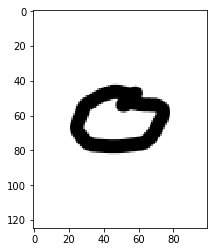

In [11]:
actual = []
for png in f_subpngs:
    if png[-6:-4] == '09':
        actual.append(1.)
    else:
        actual.append(-1.)
        
mis = [k for k, i, j in zip(range(len(y)),y, actual) if i != j]
print("The index of misclassfied period image: " + str(mis))
print(f_subpngs[17])
print("The difference for the period is: " + str(len(mis)))
img = Image.open(f_subpngs[17])
imshow(img)

From above, we find that the period classification is mistaken only one image. This image actually is 0 but was mistaken as the period. We guess that this 0 is written as too small to be recognized as the period. Then we can use the same way to classified 0 and 1. We use W value which we get from training data for 0 before. We also determine that y is 1 if it is 0, -1 otherwise.

In [12]:
W = array([-2.96119094,5.23241912,2.08514949,1.08815406,0.83625652,0.32654359,-2.31605775],dtype=float)
x = F.T
X = empty((d+1,n))
X[0,:] = 1
X[1:,:] = x

# y = 1, if it is period, otherwise y is 0
y = sign(dot(W,X))
print("The predicted number of total images: " + str(y.size))

count=0
for i in y:
    if i == 1.:
        count += 1
print("The predicted number of 0: " + str(count))

The predicted number of total images: 557
The predicted number of 0: 256


By using the same idea we used for classified the period, we can get the number of our predicated 0's images is 256, which is more than the actual images. Thus, we find the index of all images and show first seven index here with the names of the images.

In [13]:
actual = []
for png in f_subpngs:
    if png[-6:-4] == '_0':
        actual.append(1.)
    else:
        actual.append(-1.)

mis = [k for k, i, j in zip(range(len(y)),y, actual) if i != j]
print("The index of misclassfied period image: \n" + str(mis))
misimages = [f_subpngs[i] for i in mis]
print("\n")
print("The difference for the 0 is: " + str(len(misimages)))
misimages[:7]


The index of misclassfied period image: 
[367, 368, 375, 377, 378, 379, 382, 387, 388, 394, 396, 397, 398, 406, 407, 413, 415, 416, 417, 420, 425, 426, 432, 434, 435, 436, 439, 444, 445, 451, 453, 454, 455, 463, 464, 470, 472, 473, 474, 477, 482, 483, 489, 491, 492, 493, 496, 501, 502, 508, 510, 511, 512, 515, 520, 521, 527, 529, 530, 531, 534, 539, 540, 546, 548, 549, 550, 553]


The difference for the 0 is: 68


['pngs/001_20170329_adhishch__1.png',
 'pngs/001_20170329_aishanib__1.png',
 'pngs/001_20170329_kk242__1.png',
 'pngs/001_20170329_mharnold__1.png',
 'pngs/001_20170329_pshekhar__1.png',
 'pngs/001_20170329_schoudhe__1.png',
 'pngs/001_20170331_msaditya__1.png']

From above output, we find that all mistaken pngs are from seven persons. We will show one of these images each person to check the reason.

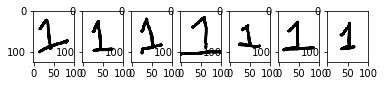

In [14]:
import matplotlib.pyplot as plt
plt.subplot(3, 7, 1)
img = Image.open('pngs/001_20170329_adhishch__1.png')
plt.imshow(img)
plt.subplot(3, 7, 2)
img = Image.open('pngs/001_20170329_aishanib__1.png')
plt.imshow(img)
plt.subplot(3, 7, 3)
img = Image.open('pngs/001_20170329_kk242__1.png')
plt.imshow(img)
plt.subplot(3, 7, 4)
img = Image.open('pngs/001_20170329_mharnold__1.png')
plt.imshow(img)
plt.subplot(3, 7, 5)
img = Image.open('pngs/001_20170329_pshekhar__1.png')
plt.imshow(img)
plt.subplot(3, 7, 6)
img = Image.open('pngs/001_20170329_schoudhe__1.png')
plt.imshow(img)
plt.subplot(3, 7, 7)
img = Image.open('pngs/001_20170331_msaditya__1.png')
plt.imshow(img)

From above images, we found that all mistaken 1's are written differently with the vertical 1s. If we remove all these one's from our data file at the beginning, it will improve our classification method a lot. 

# 4. Conclusion

From this report, we separate three characters of all students in our class. We determine six features and then import cvxopt to solve the matrix in order to find our separate W value. We first find the W by using some training data, and then we test the W by using all data in our file. From above test, we find that there are one 0 misclassified as the period since it is too small. Also, all misclassified 0 from the second separation is because people write 1 not just a straight line. Then we remove all not good one's from our data file and test our W again, we conclude that our W is good. 

# 5. Reference

[1] C. Liu, H. Fujisawa, Classification and Learning Methods for Character Recognition: Advances and Remaining Problems, Machine Learning in Document Analysis and Recognition (2008): 139-161.

# 6. Appendix

###############################
######## Data Preparation 
##############################
Populating the interactive namespace from numpy and matplotlib
pngs/000_20170329_adhishch__0.png
(125, 100, 4)
(125, 100) uint8 255


#############################
########### Traingin Data 
#############################
The length of total subpngs: 119


/Users/huiduan/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['matrix']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


     pcost       dcost       gap    pres   dres
 0:  2.4709e+00  2.6331e+01  3e+02  2e+00  1e+02
 1:  1.5774e+01 -1.1292e+01  3e+01  9e-02  7e+00
 2:  1.0347e+01  2.1880e+00  9e+00  3e-02  2e+00
 3:  1.2309e+01  6.3495e+00  6e+00  8e-03  6e-01
 4:  1.0381e+01  9.8664e+00  5e-01  5e-04  4e-02
 5:  1.0378e+01  1.0224e+01  2e-01  4e-05  3e-03
 6:  1.0362e+01  1.0360e+01  2e-03  5e-07  4e-05
 7:  1.0362e+01  1.0362e+01  2e-05  5e-09  4e-07
 8:  1.0362e+01  1.0362e+01  2e-07  5e-11  4e-09
Optimal solution found.
 The W for separating period: [ 2.11712752 -1.37894891 -1.00358281 -3.18095683 -0.18363529  0.07518996 -2.7670429 ]
The total number of subpngs without period: 79
     pcost       dcost       gap    pres   dres
 0:  2.5408e+00  3.2135e+01  2e+02  2e+00  5e+01
 1:  1.6378e+01 -1.7153e+01  5e+01  4e-01  9e+00
 2:  2.2391e+01  4.8601e+00  2e+01  6e-02  1e+00
 3:  2.2427e+01  1.0542e+01  1e+01  3e-02  7e-01
 4:  1.9768e+01  1.7624e+01  2e+00  4e-03  1e-01
 5:  1.9581e+01  1.9213e+01  4e

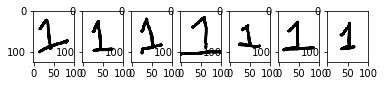

In [24]:
print("###############################\n######## Data Preparation \n##############################")
import zipfile
with zipfile.ZipFile("pngs.zip","r") as zip_ref:
    zip_ref.extractall()
from PIL import Image
import glob
%pylab inline
from numpy import *
set_printoptions(linewidth=200)
pngs = []
pngs += glob.glob('pngs/*__0.png')
pngs += glob.glob('pngs/*_09.png')
pngs += glob.glob('pngs/*__1.png')
#print(pngs)
for png in pngs:
    print (png)
    img = Image.open(png)
    imshow(img)
    a = array(img)
    print(a.shape)
    a = a[:,:,0] #select the red layer(because red,green,blue all the same)
    print(a.shape,a.dtype,a.max())
    a = array(255-a,dtype=float)
    h,w = a.shape        #h is the height, w is the width
    break
    
print("\n")    
print("#############################\n########### Traingin Data \n#############################")
subpngs = []
for png in pngs:
    if png[-15:-4] == 'aforthma_09' or png[-15:-4] == 'aforthma__0' or png[-15:-4] == 'aforthma__1':
        subpngs.append(png)
    if png[-15:-4] == 'miasette_09' or png[-15:-4] == 'miasette__0' or png[-15:-4] == 'miasette__1':
        subpngs.append(png)
    if png[-15:-4] == 'megantus_09' or png[-15:-4] == 'megantus__0' or png[-15:-4] == 'megantus__1' :
        subpngs.append(png)
    if png[-13:-4] == 'wzhu28_09' or png[-13:-4] == 'wzhu28__0' or png[-13:-4] == 'wzhu28__1':
        subpngs.append(png)
print("The length of total subpngs: " + str(len(subpngs)))

# create feature function
from numpy import *
def feturefunc(n,allpng):
    features = ['ink','width','height','topheaviness','rightheaviness','log aspect']
    d = len(features)
    F = empty((n,d))       # array of feature vectors
    for i,png in enumerate(allpng):
        img = Image.open(png)
        a = array(img)
        a = a[:,:,0]       # select the red layer(because red,green,blue all the same)
        h,w = a.shape
        x = linspace(0,w,w,endpoint = False)
        y = linspace(0,h,h,endpoint = False)

        X,Y = meshgrid(x,y)
        a = array(255-a,dtype=float)
    
        ink = a.sum()
        F[i,0] = ink/(255*w*h/5)       # can we normalize this sensibly?
    
        xmin = X[a>0].min() # the minimum x value where a>0
        xmax = X[a>0].max()
        ymin = Y[a>0].min() # the minimum x value where a>0
        ymax = Y[a>0].max()
        width  = xmax - xmin
        height = ymax - ymin
        F[i,1] = width/w
        F[i,2] = height/h
    
        xc = (xmin+xmax)/2 # center of character
        yc = (ymin+ymax)/2
    
        # total ink above center
        F[i,3] = a[Y>yc].sum()/ink
    
        # total ink right of center
        F[i,4] = a[X>xc].sum()/ink
    
        # aspect 
        F[i,5] = log10(height/width)
    return F

#seperate period
from cvxopt import matrix, solvers
d = 6
n = len(subpngs)
y = empty([1,len(subpngs)])
y = array([+1 if png[-6:-4] == '09' else -1 for png in subpngs])
#print (y)

F = feturefunc(n,subpngs)
x = F.T
#print(x)
X = empty((d+1,n))
X[0,:] = 1
X[1:,:] = x

P = eye(d+1) # diagnal matrix
P[0,0] = 0 # first element is 0
P = matrix(P)

q = zeros(d+1)
q = matrix(q)

G = (-X*y).T
G = matrix(G)

h = -ones(n)
h = matrix(h) 

sol = solvers.qp(P,q,G,h)
W = array(sol['x']).reshape(d+1)
print(" The W for separating period: " + str(W))
for png in pngs:
    if png[-15:-4] == 'aforthma_09' or png[-15:-4] == 'miasette_09' or png[-15:-4] == 'megantus_09' or png[-13:-4] == 'wzhu28_09':
        subpngs.remove(png)
print("The total number of subpngs without period: "+ str(len(subpngs)))

# seperate 0
y = empty([1,len(subpngs)])
y = array([+1 if png[-6:-4] == '_0' else -1 for png in subpngs])
d = 6
n = len(subpngs)

F = feturefunc(n,subpngs)
x = F.T
#print(x)
X = empty((d+1,n))
X[0,:] = 1
X[1:,:] = x

P = eye(d+1) # diagnal matrix
P[0,0] = 0 # first element is 0
P = matrix(P)

q = zeros(d+1)
q = matrix(q)

G = (-X*y).T
G = matrix(G)

h = -ones(n)
h = matrix(h) 

sol = solvers.qp(P,q,G,h)
W = array(sol['x']).reshape(d+1)
print(" The W for separating 0: " + str(W))

print("\n")
print("################################\n########## Test All Data\n###############################")
f_subpngs = []
for png in pngs:
    if png[-6:-4] == '09' or png[-6:-4] == '_0' or png[-6:-4] == '_1':
        f_subpngs.append(png)
    if png in subpngs:
        f_subpngs.remove(png)
    if png[-15:-4] == 'aforthma_09' or png[-15:-4] == 'miasette_09' or png[-15:-4] == 'megantus_09' or png[-13:-4] == 'wzhu28_09':
        f_subpngs.remove(png)
        
print("The total number of images:" + str(len(f_subpngs)))

count_p = 0
count_0 = 0
count_1 = 0

for png in f_subpngs:
    if png[-6:-4] == '09':
        count_p += 1
    if png[-6:-4] == '_0':
        count_0 += 1
    if png[-6:-4] == '_1':
        count_1 += 1
print("The number of period is: " + str(count_p),
      "\nThe number of 0 is: " + str(count_0),
      "\nThe number of 1 is: " + str(count_1))

d = 6
n = len(f_subpngs)
F = feturefunc(n,f_subpngs)

W = array([ 2.11712752, -1.37894891, -1.00358281,-3.18095683,-0.18363529,0.07518996,-2.7670429 ],dtype=float)
x = F.T
X = empty((d+1,n))
X[0,:] = 1
X[1:,:] = x

# y = 1, if it is period, otherwise y is 0
y = sign(dot(W,X))
print("The predicted total number of images: " + str(y.size))
#print(y)
count=0
for i in y:
    if  i == 1.:
        count += 1
print("The number of predicted number of period: " + str(count))

actual = []
for png in f_subpngs:
    if png[-6:-4] == '09':
        actual.append(1.)
    else:
        actual.append(-1.)
        
mis = [k for k, i, j in zip(range(len(y)),y, actual) if i != j]
print("The index of misclassfied period image: " + str(mis))
print(f_subpngs[17])
print("The difference for the period is: " + str(len(mis)))
img = Image.open(f_subpngs[17])
imshow(img)

W = array([-2.96119094,5.23241912,2.08514949,1.08815406,0.83625652,0.32654359,-2.31605775],dtype=float)
x = F.T
X = empty((d+1,n))
X[0,:] = 1
X[1:,:] = x

# y = 1, if it is period, otherwise y is 0
y = sign(dot(W,X))
print("The predicted number of total images: " + str(y.size))

count=0
for i in y:
    if i == 1.:
        count += 1
print("The predicted number of 0: " + str(count))

actual = []
for png in f_subpngs:
    if png[-6:-4] == '_0':
        actual.append(1.)
    else:
        actual.append(-1.)

mis = [k for k, i, j in zip(range(len(y)),y, actual) if i != j]
print("The index of misclassfied period image: \n" + str(mis))
misimages = [f_subpngs[i] for i in mis]
print("\n")
print("The difference for the 0 is: " + str(len(misimages)))
misimages[:7]

import matplotlib.pyplot as plt
plt.subplot(3, 7, 1)
img = Image.open('pngs/001_20170329_adhishch__1.png')
plt.imshow(img)
plt.subplot(3, 7, 2)
img = Image.open('pngs/001_20170329_aishanib__1.png')
plt.imshow(img)
plt.subplot(3, 7, 3)
img = Image.open('pngs/001_20170329_kk242__1.png')
plt.imshow(img)
plt.subplot(3, 7, 4)
img = Image.open('pngs/001_20170329_mharnold__1.png')
plt.imshow(img)
plt.subplot(3, 7, 5)
img = Image.open('pngs/001_20170329_pshekhar__1.png')
plt.imshow(img)
plt.subplot(3, 7, 6)
img = Image.open('pngs/001_20170329_schoudhe__1.png')
plt.imshow(img)
plt.subplot(3, 7, 7)
img = Image.open('pngs/001_20170331_msaditya__1.png')
plt.imshow(img)

print("\n")
print("##########################\n########## Improved Classified Method\n#######################")
for png in f_subpngs:
    if png[-15:-4] == 'adhishch__1' or png[-12:-4] == 'kk242__1' or png[-15:-4] == 'mharnold__1': 
        f_subpngs.remove(png)
for png in f_subpngs:
    if png[-15:-4] == 'pshekhar__1' or png[-15:-4] == 'aishanib__1':
        f_subpngs.remove(png)
for png in f_subpngs:
    if png[-15:-4] == 'schoudhe__1' or png[-15:-4] == 'msaditya__1':
        f_subpngs.remove(png)
count_p = 0
count_0 = 0
count_1 = 0

for png in f_subpngs:
    if png[-6:-4] == '09':
        count_p += 1
    if png[-6:-4] == '_0':
        count_0 += 1
    if png[-6:-4] == '_1':
        count_1 += 1
print("The number of period is: " + str(count_p),
      "\nThe number of 0 is: " + str(count_0),
      "\nThe number of 1 is: " + str(count_1))
d = 6
n = len(f_subpngs)
F = feturefunc(n,f_subpngs)

W = array([ 2.11712752, -1.37894891, -1.00358281,-3.18095683,-0.18363529,0.07518996,-2.7670429 ],dtype=float)
x = F.T
X = empty((d+1,n))
X[0,:] = 1
X[1:,:] = x

# y = 1, if it is period, otherwise y is 0
y = sign(dot(W,X))
count=0
for i in y:
    if  i == 1.:
        count += 1

actual = []
for png in f_subpngs:
    if png[-6:-4] == '09':
        actual.append(1.)
    else:
        actual.append(-1.)
        
mis = [k for k, i, j in zip(range(len(y)),y, actual) if i != j]
print("The index of misclassfied period: " + str(mis))
print("The difference for the period is: " + str(len(mis)))

W = array([-2.96119094,5.23241912,2.08514949,1.08815406,0.83625652,0.32654359,-2.31605775],dtype=float)
x = F.T
X = empty((d+1,n))
X[0,:] = 1
X[1:,:] = x

# y = 1, if it is period, otherwise y is 0
y = sign(dot(W,X))
#print(y.size)

count=0
for i in y:
    if i == 1.:
        count += 1
#print(count)

actual = []
for png in f_subpngs:
    if png[-6:-4] == '_0':
        actual.append(1.)
    else:
        actual.append(-1.)

mis = [k for k, i, j in zip(range(len(y)),y, actual) if i != j]
print("The index of misclassfied 0: " + str(mis))
print("The difference for the 0 is: " + str(len(mis)))